First look at the data and target:
   age  monthly_charges  support_calls  churn
0   56            79.23              1      1
1   69            55.07              0      1
2   46            52.66              0      0
3   32            62.74              0      0
4   60            58.08              0      1
5   25            82.28              1      1
6   38            49.97              0      0
7   56            66.03              1      1
8   36           103.19              0      1
9   40            71.20              2      1

Number of customers who churned: 805
Starting Grid Search... This might take a moment.
Fitting 5 folds for each of 9 candidates, totalling 45 fits

GRID SEARCH RESULTS
Best parameters found: {'max_depth': 5, 'n_estimators': 200}
Best cross-validation score: 0.8162

CLASSIFICATION MODEL PERFORMANCE
Accuracy: 0.8500

Detailed Report:
              precision    recall  f1-score   support

           0       0.76      0.33      0.46        39
           1   

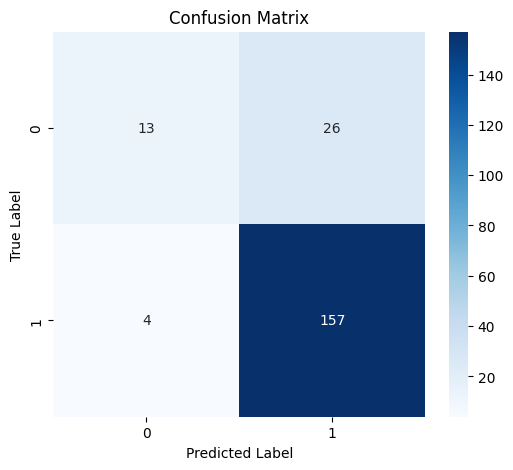


New customer prediction: Will they churn? YES
Prediction confidence: 96.69%


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
# 5. HYPERPARAMETER TUNING WITH GRIDSEARCHCV
from sklearn.model_selection import GridSearchCV


# 1. Create a more complex synthetic dataset
np.random.seed(42)
num_customers = 1000

data = {
    'customer_id': range(1, num_customers+1),
    'age': np.random.randint(18, 70, size=num_customers),
    'subscription_length_months': np.random.randint(1, 36, size=num_customers),
    'monthly_charges': np.round(np.random.normal(65, 15, num_customers), 2),
    'total_usage_gb': np.random.normal(200, 50, num_customers),
    'support_calls': np.random.poisson(0.8, size=num_customers), # New! Poisson distribution for count data
    'payment_delay': np.random.poisson(2, size=num_customers), # New!
    'region': np.random.choice(['North', 'South', 'East', 'West'], size=num_customers)
}

df = pd.DataFrame(data)

# df['monthly_value'] = (df['total_usage_gb'] / df['monthly_charges'] + np.random.normal(0, 10, num_customers))

# 2. Engineer the TARGET variable: 'churn' (1 = yes, 0 = no)
# Let's create a logical pattern: Churn is more likely for older subscribers, higher charges, and more support calls.
churn_probability = (0.3 * (df['age'] / 70) +
                     0.5 * (df['monthly_charges'] / 80) +
                     0.2 * (df['support_calls'] / 4)
                     # 0.3 * (df['monthly_value'] / 1)
                     )
# Add some randomness
churn_probability += np.random.normal(0, 0.1, num_customers)
# Convert probabilities to actual 1/0 outcomes
df['churn'] = (churn_probability > 0.5).astype(int)

print("First look at the data and target:")
print(df[['age', 'monthly_charges', 'support_calls', 'churn']].head(10))
print(f"\nNumber of customers who churned: {df['churn'].sum()}")

# 3. Prepare the data (handle categories, define X and y)
X = pd.get_dummies(df[['age', 'subscription_length_months', 'monthly_charges', 'total_usage_gb', 'support_calls', 'payment_delay', 'region']], drop_first=True) # 'monthly_value',
y = df['churn']

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 'stratify' keeps the class ratio balanced

# 5. Train a CLASSIFICATION model
# model = LogisticRegression(max_iter=1000)
model = RandomForestClassifier(n_estimators=50, max_depth=2 , random_state= 42) # This is for classification!

# Next, define the "grid" of parameters you want to search over
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [2, 5, 10],         # Maximum depth of each tree
    # You can add more parameters to search here, like 'min_samples_split'
}

# Create the GridSearchCV object
# cv=5 means it will use 5-fold cross-validation for each combination
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', # You can change this to 'f1' or 'recall' if you prefer
    verbose=1, # This prints out progress so you can see it working
    n_jobs = -1 # Uses all your computer's processors to run faster
)

# Now, fit it to your training data. This will try ALL combinations.
print("Starting Grid Search... This might take a moment.")
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("\n" + "="*50)
print("GRID SEARCH RESULTS")
print("="*50)
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# 6. Make predictions and evaluate
y_pred = best_model.predict(X_test)

# NEW METRICS FOR CLASSIFICATION
print("\n" + "="*50)
print("CLASSIFICATION MODEL PERFORMANCE")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred))

# NEW: Confusion Matrix - shows exactly where the model succeeds and fails
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 7. Predict on a new customer
new_customer = pd.DataFrame({
    'age': [45],
    'subscription_length_months': [12],
    'monthly_charges': [80],
    'total_usage_gb': [150],
    'support_calls': [3],
    'payment_delay': [2],
    'region_North': [0],
    'region_South': [1],
    'region_West': [0]
    # 'region_East' is dropped due to 'drop_first=True'
})

prediction = best_model.predict(new_customer)
prediction_proba = best_model.predict_proba(new_customer)
print(f"\nNew customer prediction: Will they churn? {'YES' if prediction[0] == 1 else 'NO'}")
print(f"Prediction confidence: {prediction_proba[0][prediction[0]]:.2%}")